# Get started

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/101-get_started.ipynb)

This notebook contains the simple examples of time series forecasting pipeline
using ETNA library.

**Table of contents**

* [Loading dataset](#chapter1)
* [Plotting](#chapter2)
* [Forecasting single time series](#chapter3)
    * [Naive forecast](#section_3_1)
    * [Prophet](#section_3_2)
    * [Catboost](#section_3_3)
* [Forecasting multiple time series](#chapter4)

In [1]:
pip install etna

In [2]:
!pip install "etna[prophet]" -q

In [4]:
import warnings

import pandas as pd

## 1. Loading dataset <a class="anchor" id="chapter1"></a>

Let's load and look at the dataset

In [3]:
import pandas as pd

# Загружаем все три файла
dates_df = pd.read_csv('/content/shop_sales_dates.csv')
prices_df = pd.read_csv('/content/shop_sales_prices.csv')
sales_df = pd.read_csv('/content/shop_sales.csv')



In [6]:
merged_df = sales_df.merge(dates_df[['date', 'date_id', 'wm_yr_wk']], on='date_id', how='left')
merged_df.head()

item_id store_id  date_id  cnt        date  wm_yr_wk
0  STORE_2_085  STORE_2        1    3  2011-01-29     11101
1  STORE_2_085  STORE_2        2    8  2011-01-30     11101
2  STORE_2_085  STORE_2        3    0  2011-01-31     11101
3  STORE_2_085  STORE_2        4    3  2011-02-01     11101
4  STORE_2_085  STORE_2        5    0  2011-02-02     11101

Library works with a special data structure called `TSDataset`. It stores all the necessary information to work with multiple time series.

To create an instance of `TSDataset` we should reformat our `df` into one of two supported formats:

- Long format
  - Has columns `timestamp`, `segment`, `target`
  - Column `timestamp` stores timestamp values
  - Column `target` stores values of time series
  - Column `segment` stores identifiers of different time series
- Wide format
  - Index stores timestamp values
  - Columns has two levels with names 'segment', 'feature'. Each column stores values for a given feature in a given segment.

More details about the formats could be found in documentation for `etna.datasets.DataFrameFormat`.

Usually it is much easier to create dataframe in a long format. So, let's do it!

In [7]:
df = merged_df[['item_id', 'date', 'cnt']]
df["timestamp"] = pd.to_datetime(df["date"])
df["target"] = df["cnt"]
df['segment'] = df['item_id']
df.drop(columns=["date", "cnt", 'item_id'], inplace=True)
df.head()

<ipython-input-7-838f36bd9318>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["timestamp"] = pd.to_datetime(df["date"])
<ipython-input-7-838f36bd9318>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df["cnt"]


timestamp  target      segment
0 2011-01-29       3  STORE_2_085
1 2011-01-30       8  STORE_2_085
2 2011-01-31       0  STORE_2_085
3 2011-02-01       3  STORE_2_085
4 2011-02-02       0  STORE_2_085




Библиотека работает со специальной структурой данных под названием TSDataset. Она хранит всю необходимую информацию для работы с несколькими временными рядами.
Чтобы создать экземпляр TSDataset, мы должны преобразовать наш df в один из двух поддерживаемых форматов:

Длинный формат

Имеет столбцы timestamp, segment, target
Столбец timestamp хранит значения временных меток
Столбец target хранит значения временного ряда
Столбец segment хранит идентификаторы различных временных рядов


Широкий формат

Индекс хранит значения временных меток
Столбцы имеют два уровня с названиями 'segment' и 'feature'. Каждый столбец хранит значения для данного признака в данном сегменте.



Более подробную информацию о форматах можно найти в документации для etna.datasets.DataFrameFormat.

In [8]:
#приводим к одному сегменту(один sku)
df = df[df['segment'] == 'STORE_2_085']
df.head()

timestamp  target      segment
0 2011-01-29       3  STORE_2_085
1 2011-01-30       8  STORE_2_085
2 2011-01-31       0  STORE_2_085
3 2011-02-01       3  STORE_2_085
4 2011-02-02       0  STORE_2_085

To get a wide format from a long format the `TSDataset.to_dataset` could be used:

In [9]:
from etna.datasets.tsdataset import TSDataset

wide_df = TSDataset.to_dataset(df)
wide_df.head()

/usr/local/lib/python3.10/dist-packages/etna/settings.py:37: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
/usr/local/lib/python3.10/dist-packages/etna/settings.py:45: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
/usr/local/lib/python3.10/dist-packages/etna/settings.py:62: UserWarning: etna[classification] is not available, to install it, run `pip install etna[classification]`
  warnings.warn("etna[classification] is not available, to install it, run `pip install etna[classification]`")
/usr/local/lib/python3.10/dist-packages/etna/settings.py:71: UserWarning: etna[auto] is not available, to install it, run `pip install etna[auto]`
  warnings.warn("etna[auto] is not available, to install it, run `pip install etna[auto]`")
/usr/loc

segment    STORE_2_085
feature         target
timestamp             
2011-01-29           3
2011-01-30           8
2011-01-31           0
2011-02-01           3
2011-02-02           0

Time to create a `TSDataset`! Additionally to passing a dataframe we should specify the frequency of our data.
In this case it is monthly data.

In [10]:
ts = TSDataset(df, freq="1M")
ts.head()

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:352: UserWarning: You probably set wrong freq. Discovered freq in you data is D, you set 1M
  warnings.warn(


segment    STORE_2_085
feature         target
timestamp             
2011-01-31           0
2011-02-28           1
2011-03-31           0
2011-04-30           1
2011-05-31           0

Oups. Let's fix that by looking at the [table of offsets in pandas](https://pandas.pydata.org/docs/user_guide/timeseries.html#dateoffset-objects):

In [11]:
ts = TSDataset(df, freq="MS")
ts.head()

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:352: UserWarning: You probably set wrong freq. Discovered freq in you data is D, you set MS
  warnings.warn(


segment    STORE_2_085
feature         target
timestamp             
2011-02-01           3
2011-03-01           4
2011-04-01           2
2011-05-01           4
2011-06-01           0

We can look at the basic information about the dataset

In [12]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: MS
            start_timestamp end_timestamp  length  num_missing
segments                                                      
STORE_2_085      2011-02-01    2016-01-01      60            0


Or in `DataFrame` format

In [13]:
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                       
STORE_2_085      2011-02-01    2016-01-01      60            0             1   

             num_exogs  num_regressors  num_known_future freq  
segments                                                       
STORE_2_085          0               0                 0   MS

Library also has several internal public datasets. You can use them to compare some models with public benchmarks. It is easy to use:

You can get the full list of available internal datasets:

In [14]:
from etna.datasets.internal_datasets import list_datasets

print(list_datasets())

['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2', 'IHEPC_T', 'australian_wine_sales_monthly', 'electricity_15T', 'm3_monthly', 'm3_other', 'm3_quarterly', 'm3_yearly', 'm4_daily', 'm4_hourly', 'm4_monthly', 'm4_quarterly', 'm4_weekly', 'm4_yearly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'traffic_2008_10T', 'traffic_2008_hourly', 'traffic_2015_hourly', 'weather_10T']


More information about internal datasets can be found in this [documentation page](https://docs.etna.ai/stable/internal_datasets.html).

## 2. Plotting <a class="anchor" id="chapter2"></a>

Let's take a look at the time series in the dataset

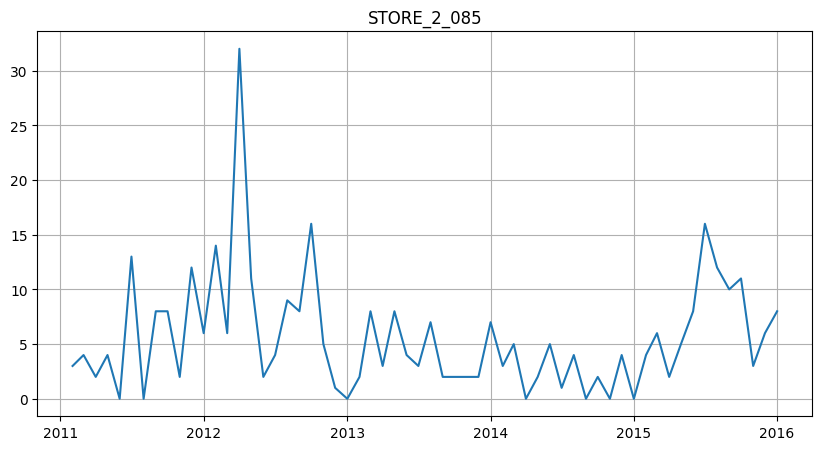

In [15]:
ts.plot()

## 3. Forecasting single time series <a class="anchor" id="chapter3"></a>

Our library contains a wide range of different models for time series forecasting. Let's look at some of them.

In [16]:
warnings.filterwarnings("ignore")

Let's predict the monthly values in 1994 for our dataset.

In [17]:
HORIZON = 8

In [18]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

### 3.1 Naive forecast <a class="anchor" id="section_3_1"></a>

We will start by using the `NaiveModel` that just takes the value from `lag` time steps before.

This model doesn't require any features, so to make a forecast we should define pipeline with this model and set a proper horizon value.

In [19]:
from etna.models import NaiveModel
from etna.pipeline import Pipeline

# Define a model
model = NaiveModel(lag=12)

# Define a pipeline
pipeline = Pipeline(model=model, horizon=HORIZON)

Let's make a forecast.

In [20]:
# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()

Calling `pipeline.forecast` without parameters makes a forecast for the next `HORIZON` points after the end of the training set.

In [21]:
forecast_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: MS
            start_timestamp end_timestamp  length  num_missing
segments                                                      
STORE_2_085      2015-06-01    2016-01-01       8            0


Now let's look at the result metric and plot the prediction. All the methods already built-in in ETNA.

In [22]:
from etna.metrics import SMAPE, MAE

mae = MAE()
mae(y_true=test_ts, y_pred=forecast_ts)

{'STORE_2_085': 7.25}

In [23]:
import math

In [24]:
sum(mae(y_true=test_ts, y_pred=forecast_ts).values())/len(mae(y_true=test_ts, y_pred=forecast_ts).values())

7.25

In [25]:
from etna.metrics import SMAPE, MAE

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'STORE_2_085': 137.63574660633483}

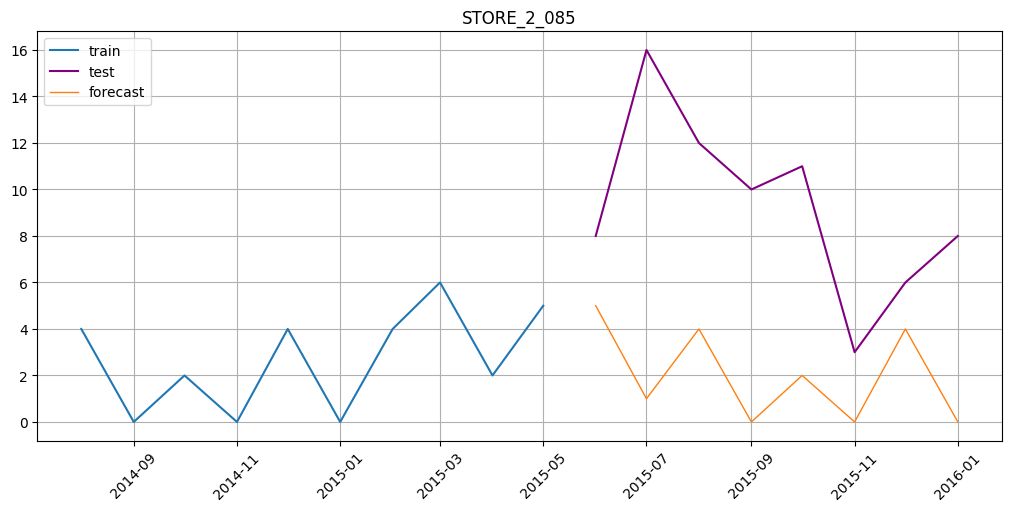

In [26]:
from etna.analysis import plot_forecast

plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=10)

### 3.2 Prophet<a class="anchor" id="section_3_2"></a>

Now we can try to improve the forecast by using Prophet model.

In [27]:
from etna.models import ProphetModel

# Define a model
model = ProphetModel()

# Define a pipeline
pipeline = Pipeline(model=model, horizon=HORIZON)

# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwx5jyyws/2tre3hdy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwx5jyyws/x3eyj1rx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19944', 'data', 'file=/tmp/tmpwx5jyyws/2tre3hdy.json', 'init=/tmp/tmpwx5jyyws/x3eyj1rx.json', 'output', 'file=/tmp/tmpwx5jyyws/prophet_model0mbze927/prophet_model-20240911164903.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:49:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:49:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [28]:
mae(y_true=test_ts, y_pred=forecast_ts)

{'STORE_2_085': 6.900714609121513}

In [29]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'STORE_2_085': 125.66318762319253}

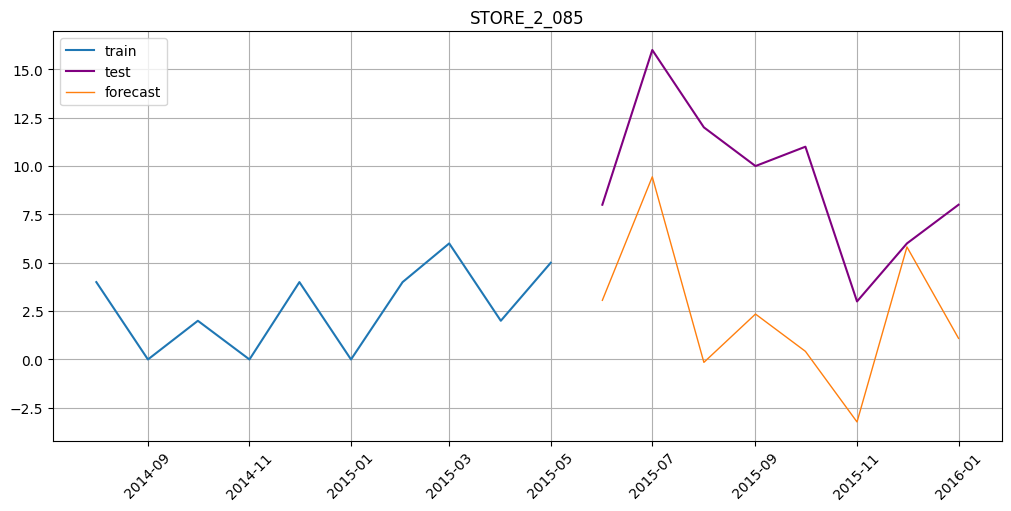

In [28]:
plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=10)

### 3.3 Catboost <a class="anchor" id="section_3_3"></a>

Finally, let's try the ML-model. This kind of models require some features to make a forecast.

#### 3.3.1 Basic transforms

ETNA has a wide variety of transforms to work with data, let's take a look at some of them.

**Lags**

Lag transformation is the most basic one. It gives us some previous value of the time series. For example, the first lag is the previous value, and the fifth lag is the value five steps ago. Lags are essential for regression models, like linear regression or boosting, because they allow these models to grasp information about the past.

The scheme of working:

![lags-scheme](./assets/get_started/lags.gif)

In [30]:
from etna.transforms import LagTransform

lags = LagTransform(in_column="target", lags=list(range(HORIZON, 24)), out_column="lag")

There are some limitations on available lags during the forecasting. Imagine that we want to make a forecast for 3 step ahead. We can't take the previous value when we make a forecast for the last step, we just don't know the value. For this reason, you should use `lags` >= `HORIZON` when using a `Pipeline`.

**Statistics**

Statistics are another essential feature. It is also useful for regression models as it allows them to look at the information about the past but in different ways than lags. There are different types of statistics: mean, median, standard deviation, minimum and maximum on the interval.

The scheme of working:

![statistics-scheme](./assets/get_started/statistics.gif)

As we can see, the window includes the current timestamp. For this reason, we shouldn't apply the statistics transformations to target variable, we should apply it to lagged target variable.

In [31]:
from etna.transforms import MeanTransform

mean = MeanTransform(in_column=f"lag_{HORIZON}", window=12)

**Dates**

The time series also has the timestamp column that we have not used yet. But date number in a week and in a month, as well as week number in year or weekend flag can be really useful for the machine learning model. And ETNA allows us to extract all this information with `DateFlagTransform`.

In [32]:
from etna.transforms import DateFlagsTransform

date_flags = DateFlagsTransform(
    day_number_in_week=False,
    day_number_in_month=False,
    week_number_in_month=False,
    month_number_in_year=True,
    season_number=True,
    is_weekend=False,
    out_column="date_flag",
)

**Logarithm**

However, there is another type of transform that alters the column itself. We call it “inplace transform”. The easiest is `LogTransform`. It logarithms values in a column.

In [33]:
from etna.transforms import LogTransform

log = LogTransform(in_column="target", inplace=True)

#### 3.3.2 Forecasting

Now let's pass these transforms into our `Pipeline`. It will do all the work with applying the transforms and making exponential inverse transformation after the prediction.

In [34]:
train_ts

segment    STORE_2_085
feature         target
timestamp             
2011-02-01           3
2011-03-01           4
2011-04-01           2
2011-05-01           4
2011-06-01           0
2011-07-01          13
2011-08-01           0
2011-09-01           8
2011-10-01           8
2011-11-01           2
2011-12-01          12
2012-01-01           6
2012-02-01          14
2012-03-01           6
2012-04-01          32
2012-05-01          11
2012-06-01           2
2012-07-01           4
2012-08-01           9
2012-09-01           8
2012-10-01          16
2012-11-01           5
2012-12-01           1
2013-01-01           0
2013-02-01           2
2013-03-01           8
2013-04-01           3
2013-05-01           8
2013-06-01           4
2013-07-01           3
2013-08-01           7
2013-09-01           2
2013-10-01           2
2013-11-01           2
2013-12-01           2
2014-01-01           7
2014-02-01           3
2014-03-01           5
2014-04-01           0
2014-05-01           2
2014-06-01           5
2014-07-01           1
2014-08-01           4
2014-09-01           0
2014-10-01           2
2014-11-01           0
2014-12-01           4
2015-01-01           0
2015-02-01           4
2015-03-01           6
2015-04-01           2
2015-05-01           5

In [35]:
from etna.models import CatBoostMultiSegmentModel

# Define transforms
transforms = [lags, mean, date_flags, log]

# Define a model
model = CatBoostMultiSegmentModel()

# Define a pipeline
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()

In [36]:
df.target.mean()

5.5997800989554705

In [37]:
mae(y_true=test_ts, y_pred=forecast_ts)

{'STORE_2_085': 7.442270788753127}

In [38]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'STORE_2_085': 127.62816437234963}

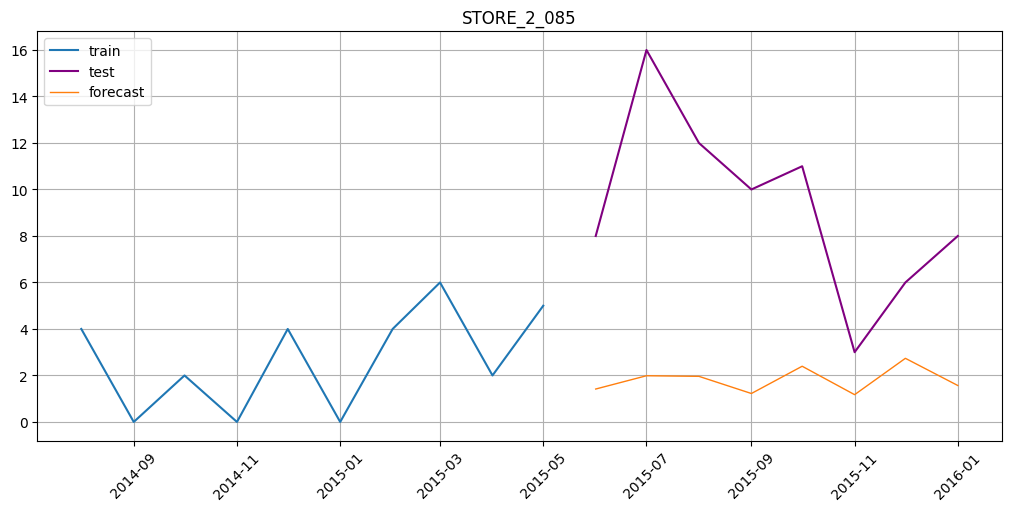

In [37]:
plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=10)

## 4. Forecasting multiple time series <a class="anchor" id="chapter4"></a>

In this section you may see example of how easily ETNA works with multiple time series and get acquainted with other transforms the library contains.

In [39]:
final_merged_df = merged_df.merge(prices_df, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
final_merged_df

item_id store_id  date_id  cnt        date  wm_yr_wk  sell_price
0      STORE_2_085  STORE_2        1    3  2011-01-29     11101        1.00
1      STORE_2_085  STORE_2        2    8  2011-01-30     11101        1.00
2      STORE_2_085  STORE_2        3    0  2011-01-31     11101        1.00
3      STORE_2_085  STORE_2        4    3  2011-02-01     11101        1.00
4      STORE_2_085  STORE_2        5    0  2011-02-02     11101        1.00
...            ...      ...      ...  ...         ...       ...         ...
81850  STORE_1_727  STORE_1     1815    2  2016-01-17     11551        4.48
81851  STORE_1_727  STORE_1     1816    3  2016-01-18     11551        4.48
81852  STORE_1_727  STORE_1     1817    1  2016-01-19     11551        4.48
81853  STORE_1_727  STORE_1     1818    4  2016-01-20     11551        4.48
81854  STORE_1_727  STORE_1     1819    2  2016-01-21     11551        4.48

[81855 rows x 7 columns]

In [40]:
df = final_merged_df[['item_id', 'date', 'cnt', 'sell_price']]
df["timestamp"] = pd.to_datetime(df["date"])
df["target"] = df["cnt"]
df['segment'] = df['item_id']
df['price'] = df['sell_price']
df.drop(columns=["date", "cnt", 'item_id', 'sell_price'], inplace=True)
df.head()

timestamp  target      segment  price
0 2011-01-29       3  STORE_2_085    1.0
1 2011-01-30       8  STORE_2_085    1.0
2 2011-01-31       0  STORE_2_085    1.0
3 2011-02-01       3  STORE_2_085    1.0
4 2011-02-02       0  STORE_2_085    1.0

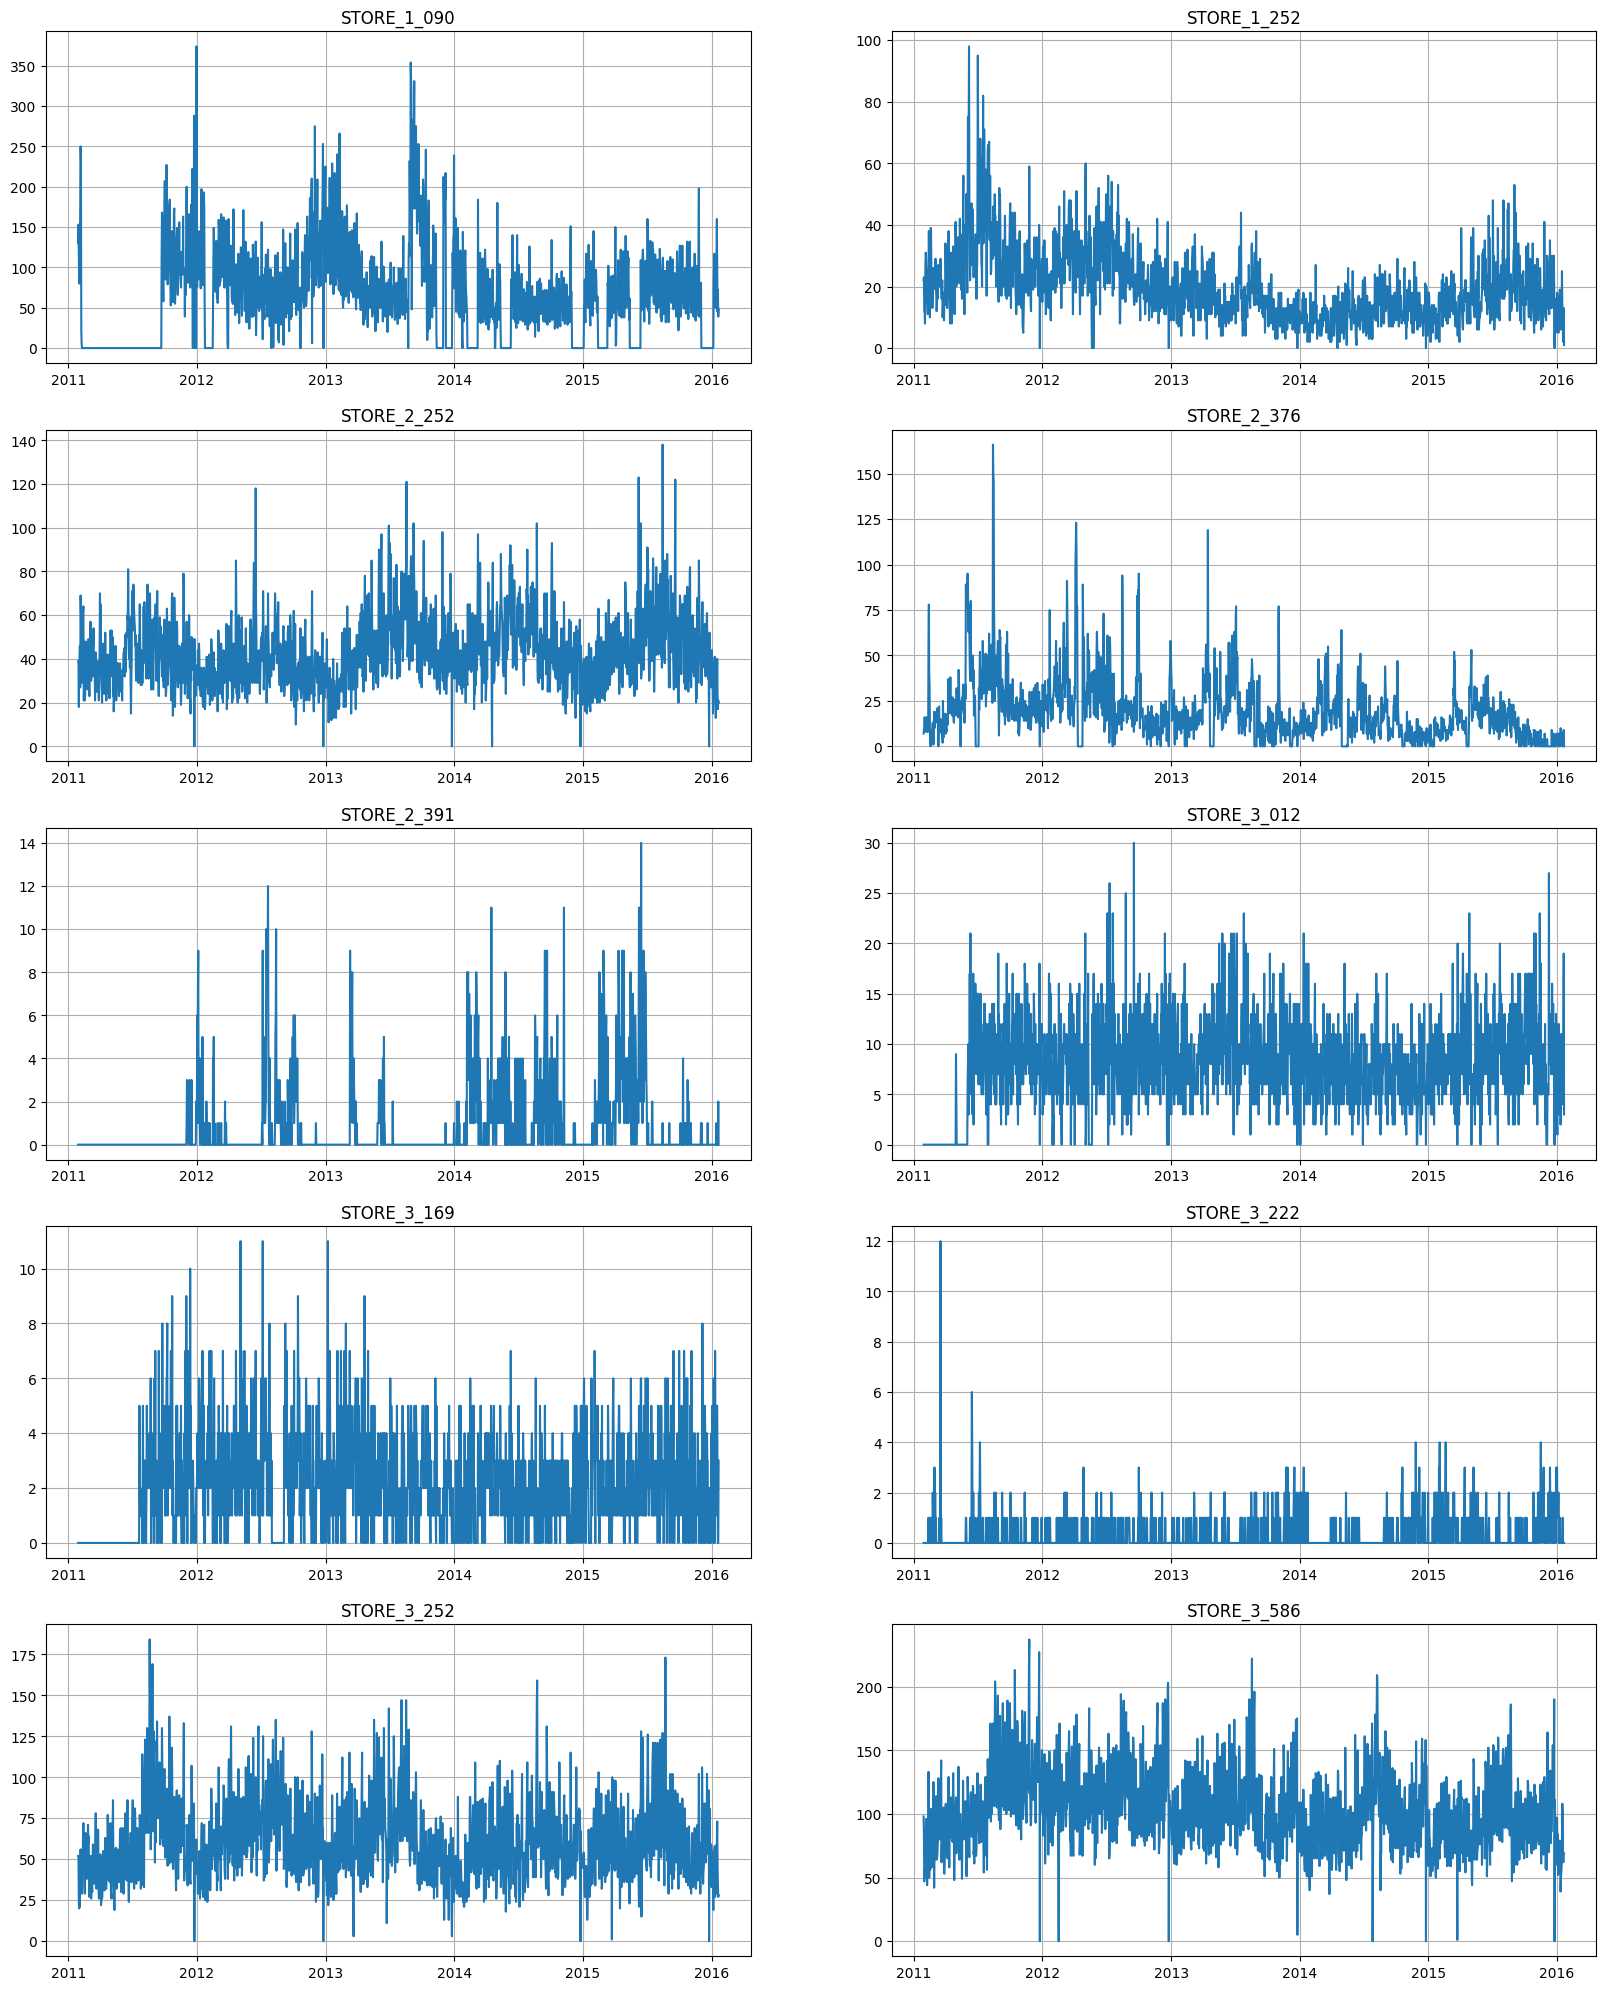

In [41]:
ts = TSDataset(df, freq="D")
ts.plot()

In [42]:
ts

segment    STORE_1_064        STORE_1_065        STORE_1_090         \
feature          price target       price target       price target   
timestamp                                                             
2011-01-29        2.54      0        2.94      0        1.25    130   
2011-01-30        2.54      1        2.94      0        1.25    153   
2011-01-31        2.54      0        2.94      2        1.25    119   
2011-02-01        2.54      0        2.94      0        1.25     80   
2011-02-02        2.54      0        2.94      0        1.25     80   
...                ...    ...         ...    ...         ...    ...   
2016-01-17        2.68      0        3.54      0        1.38     96   
2016-01-18        2.68      0        3.54      0        1.38     45   
2016-01-19        2.68      0        3.54      1        1.38     72   
2016-01-20        2.68      1        3.54      2        1.38     39   
2016-01-21        2.68      0        3.54      1        1.38     48   

segment    STORE_1_252        STORE_1_325         ... STORE_3_555         \
feature          price target       price target  ...       price target   
timestamp                                         ...                      
2011-01-29        1.48     22         NaN      0  ...        1.48     63   
2011-01-30        1.48     23         NaN      0  ...        1.48     49   
2011-01-31        1.48     12         NaN      0  ...        1.48     43   
2011-02-01        1.48     12         NaN      0  ...        1.48     26   
2011-02-02        1.48      8         NaN      0  ...        1.48     26   
...                ...    ...         ...    ...  ...         ...    ...   
2016-01-17        1.58     13        1.25      6  ...        1.68     58   
2016-01-18        1.58      2        1.25      6  ...        1.68     37   
2016-01-19        1.58      8        1.25      2  ...        1.68     34   
2016-01-20        1.58     13        1.25      7  ...        1.68     36   
2016-01-21        1.58      1        1.25      2  ...        1.68     19   

segment    STORE_3_586        STORE_3_587        STORE_3_714         \
feature          price target       price target       price target   
timestamp                                                             
2011-01-29        1.48     98        2.28     59        1.48     26   
2011-01-30        1.48     85        2.28     34        1.48     26   
2011-01-31        1.48     47        2.28     37        1.48     24   
2011-02-01        1.48     56        2.28      7        1.48     15   
2011-02-02        1.48     51        2.28      0        1.48     15   
...                ...    ...         ...    ...         ...    ...   
2016-01-17        1.68    101        2.48     50        1.58     11   
2016-01-18        1.68     66        2.48     37        1.58     14   
2016-01-19        1.68     62        2.48     23        1.58     10   
2016-01-20        1.68     68        2.48     24        1.58      9   
2016-01-21        1.68     69        2.48     32        1.58     15   

segment    STORE_3_804         
feature          price target  
timestamp                      
2011-01-29        1.88      4  
2011-01-30        1.88      6  
2011-01-31        1.88      4  
2011-02-01        1.88      3  
2011-02-02        1.88      4  
...                ...    ...  
2016-01-17        1.88     21  
2016-01-18        1.88     28  
2016-01-19        1.88      5  
2016-01-20        1.88      8  
2016-01-21        1.88     17  

[1819 rows x 90 columns]

In [43]:
HORIZON = 30

In [84]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

In [73]:
test_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 45
num_exogs: 1
num_regressors: 0
num_known_future: 0
freq: D
            start_timestamp end_timestamp  length  num_missing
segments                                                      
STORE_1_064      2015-12-23    2016-01-21      30            0
STORE_1_065      2015-12-23    2016-01-21      30            0
STORE_1_090      2015-12-23    2016-01-21      30            0
STORE_1_252      2015-12-23    2016-01-21      30            0
STORE_1_325      2015-12-23    2016-01-21      30            0
STORE_1_339      2015-12-23    2016-01-21      30            0
STORE_1_376      2015-12-23    2016-01-21      30            0
STORE_1_546      2015-12-23    2016-01-21      30            0
STORE_1_547      2015-12-23    2016-01-21      30            0
STORE_1_555      2015-12-23    2016-01-21      30            0
STORE_1_584      2015-12-23    2016-01-21      30            0
STORE_1_586      2015-12-23    2016-01-21      30            0
STORE_1_

In [81]:
from etna.transforms import LinearTrendTransform
from etna.transforms import SegmentEncoderTransform
from etna.models import SARIMAXModel

# Define transforms
log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()
lags = LagTransform(in_column="target", lags=list(range(HORIZON, 96)), out_column="lag")
date_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    is_weekend=True,
)
mean = MeanTransform(in_column=f"lag_{HORIZON}", window=30)
transforms = [log, trend, lags, date_flags, seg, mean]

# Define a model
model = NaiveModel()

# Define a pipeline
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()

mae(y_true=test_ts, y_pred=forecast_ts)

{'STORE_1_064': 0.13435108753232006,
 'STORE_1_065': 0.5001176882936611,
 'STORE_1_090': 41.2946509295584,
 'STORE_1_252': 5.136174937682595,
 'STORE_1_325': 3.33950012303269,
 'STORE_1_339': 2.499949300815779,
 'STORE_1_376': 0.4034387893129271,
 'STORE_1_546': 2.8047082662576015,
 'STORE_1_547': 16.78219029725756,
 'STORE_1_555': 8.337536343985148,
 'STORE_1_584': 1.3417996552200238,
 'STORE_1_586': 10.123424898716712,
 'STORE_1_587': 10.51576359789138,
 'STORE_1_714': 10.123806978980499,
 'STORE_1_727': 4.7479424928499165,
 'STORE_2_043': 0.1674338441650157,
 'STORE_2_054': 2.37369754271148,
 'STORE_2_085': 3.4994912946594736,
 'STORE_2_090': 46.16381976644629,
 'STORE_2_252': 8.803620447271776,
 'STORE_2_325': 7.96041573762444,
 'STORE_2_376': 4.436798051182314,
 'STORE_2_391': 0.10377468897040316,
 'STORE_2_524': 6.802336878351981,
 'STORE_2_555': 27.122536454576814,
 'STORE_2_586': 38.025363750135845,
 'STORE_2_587': 9.40078615279556,
 'STORE_2_681': 15.406875608328859,
 'STORE_2

In [82]:
print('avg mae:', sum(mae(y_true=test_ts, y_pred=forecast_ts).values())/len(mae(y_true=test_ts, y_pred=forecast_ts).values()))

avg mae: 10.471786060040294


In [74]:
from etna.transforms import LinearTrendTransform
from etna.transforms import SegmentEncoderTransform

# Define transforms
log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()
lags = LagTransform(in_column="target", lags=list(range(HORIZON, 96)), out_column="lag")
date_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    is_weekend=True,
)
mean = MeanTransform(in_column=f"lag_{HORIZON}", window=30)
transforms = [log, trend, lags, date_flags, seg, mean]

# Define a model
model = CatBoostMultiSegmentModel()

# Define a pipeline
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()

mae(y_true=test_ts, y_pred=forecast_ts)

{'STORE_1_064': 0.42103778957209753,
 'STORE_1_065': 0.7374556277878085,
 'STORE_1_090': 35.5164251718893,
 'STORE_1_252': 3.6966622974983014,
 'STORE_1_325': 3.5109931859446903,
 'STORE_1_339': 2.151379756904571,
 'STORE_1_376': 0.6078953816431799,
 'STORE_1_546': 1.5927702160172503,
 'STORE_1_547': 13.473217812548286,
 'STORE_1_555': 6.954992608947455,
 'STORE_1_584': 0.9884208055381397,
 'STORE_1_586': 6.842237921809409,
 'STORE_1_587': 25.46408224214639,
 'STORE_1_714': 3.9270665486499556,
 'STORE_1_727': 2.923667289945798,
 'STORE_2_043': 0.6491214148023807,
 'STORE_2_054': 2.7502914882602356,
 'STORE_2_085': 2.959469925007563,
 'STORE_2_090': 34.75703818621403,
 'STORE_2_252': 15.66563439064497,
 'STORE_2_325': 3.1714012441303043,
 'STORE_2_376': 3.0541003483037703,
 'STORE_2_391': 0.573324109452789,
 'STORE_2_524': 6.0187864771398365,
 'STORE_2_555': 8.046380612138774,
 'STORE_2_586': 23.716610996650953,
 'STORE_2_587': 18.628111008580397,
 'STORE_2_681': 20.70791007473185,
 'ST

In [75]:
print('avg mae:', sum(mae(y_true=test_ts, y_pred=forecast_ts).values())/len(mae(y_true=test_ts, y_pred=forecast_ts).values()))

avg mae: 8.794606525224422


In [54]:
from etna.transforms import LinearTrendTransform
from etna.transforms import SegmentEncoderTransform
from etna.models import ElasticMultiSegmentModel

# Define transforms
log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()
lags = LagTransform(in_column="target", lags=list(range(HORIZON, 96)), out_column="lag")
date_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    is_weekend=True,
)
mean = MeanTransform(in_column=f"lag_{HORIZON}", window=30)
transforms = [log, trend, lags, date_flags, seg, mean]

# Define a model
model = ElasticMultiSegmentModel()

# Define a pipeline
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()


In [55]:
print('avg mae:', sum(mae(y_true=test_ts, y_pred=forecast_ts).values())/len(mae(y_true=test_ts, y_pred=forecast_ts).values()))

avg mae: 10.040758867438257


In [67]:
from etna.transforms import LinearTrendTransform
from etna.transforms import SegmentEncoderTransform
from etna.models import LinearMultiSegmentModel

# Define transforms
log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()
lags = LagTransform(in_column="target", lags=list(range(HORIZON, 96)), out_column="lag")
date_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    is_weekend=True,
)
mean = MeanTransform(in_column=f"lag_{HORIZON}", window=30)
transforms = [log, trend, lags, date_flags, seg, mean]

# Define a model
model = LinearMultiSegmentModel()

# Define a pipeline
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()


In [68]:
print('avg mae:', sum(mae(y_true=test_ts, y_pred=forecast_ts).values())/len(mae(y_true=test_ts, y_pred=forecast_ts).values()))

avg mae: 9.812515506986395


In [71]:
from etna.transforms import LinearTrendTransform
from etna.transforms import SegmentEncoderTransform
from etna.models import ProphetModel

# Define transforms
log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()
lags = LagTransform(in_column="target", lags=list(range(HORIZON, 96)), out_column="lag")
date_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    is_weekend=True,
)
mean = MeanTransform(in_column=f"lag_{HORIZON}", window=30)
transforms = [log, trend, lags, date_flags, seg, mean]

# Define a model
model = ProphetModel()

# Define a pipeline
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

# Fit the pipeline
pipeline.fit(train_ts)

# Make a forecast
forecast_ts = pipeline.forecast()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwx5jyyws/m2k8g53n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwx5jyyws/kz0ghpur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40891', 'data', 'file=/tmp/tmpwx5jyyws/m2k8g53n.json', 'init=/tmp/tmpwx5jyyws/kz0ghpur.json', 'output', 'file=/tmp/tmpwx5jyyws/prophet_modelppx7iwq0/prophet_model-20240911170359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwx

In [72]:
print('avg mae:', sum(mae(y_true=test_ts, y_pred=forecast_ts).values())/len(mae(y_true=test_ts, y_pred=forecast_ts).values()))

avg mae: 7.7003127549779835


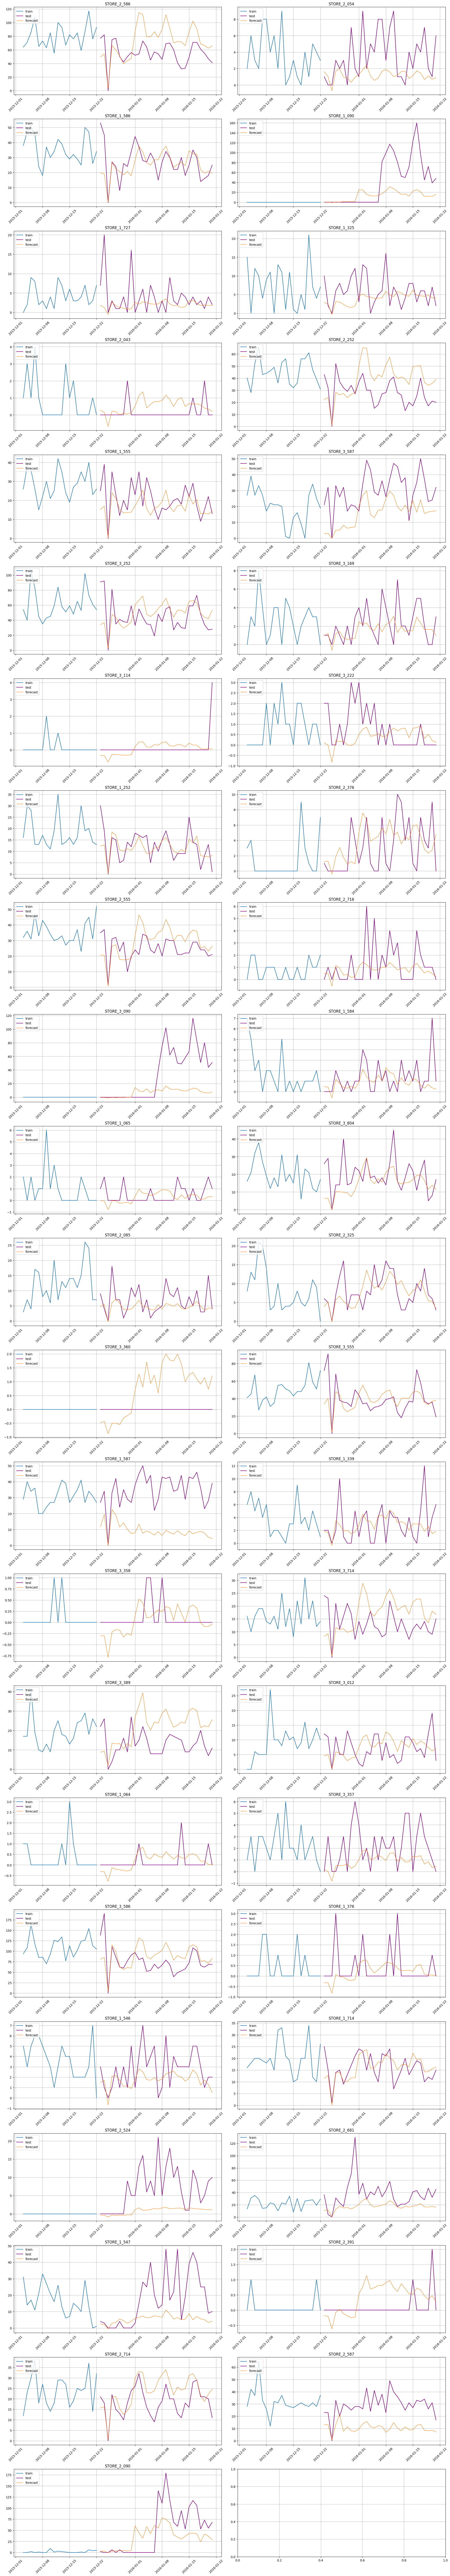

In [48]:
plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=20)